#
#   Stochastic Processes - class 1/2024 - University of Brasília
#   Computational work 1 - Requantization and image analysis
#
#   Gabriel Tambara Rabelo - 241106461
#
#   References:
#   https://docs.opencv.org/4.x/d1/db7/tutorial_py_histogram_begins.html
#   https://docs.opencv.org/4.9.0/d4/d1b/tutorial_histogram_equalization.html
#   https://docs.opencv.org/3.4/d1/d5c/tutorial_py_kmeans_opencv.html
#

In [421]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from math import sqrt
from math import floor

img_size = 300
images_addr = ["folha.jpg", "torso.png", "coisa.jpg", "cerebro.jpg", "cerebro-tumor.jpg"]
images_addr.sort()
images = []

# control of when to stop showing images and progressing in the processing
def waitKey():
    cv.waitKey(0)
    cv.destroyAllWindows()

# show images
def printAll(list, subtitle):
    for i in range(len(list)):
        cv.imshow(images_addr[i] + subtitle, list[i])

# save images in the correct folder
def saveAll(list, subtitle):
    for i in range(len(list)):
        cv.imwrite("./images/" + images_addr[i][0:-4] + subtitle + images_addr[i][-4:], list[i])

def makeHist(image_list, bits):
    histList = []
    for i in range(len(image_list)):
        hist = []
        bins = np.arange(0, 257, 2 ** (8 - bits)) #257 since the bins must be 1 more than what it shows and we need even 1 more since arange excludes the last one

        if(bits <= 0 or bits > 8):
            print("bitsize our of bounds")
            exit()

        image = image_list[i].flatten()
        #for pixel_intensity in bins:
        #    hist.append(np.sum(image == pixel_intensity))
        #    print(str(hist[-1]))
        hist, bins_new = np.histogram(image, bins=bins)

        histList.append((hist, bins))
    return histList

def normalizeHist(histList):
    normalizedHistList = []
    for hist, bins in histList:
        total_pixels = np.sum(hist)
        normalized_hist = hist / (total_pixels)
        normalizedHistList.append((normalized_hist, bins))
    return normalizedHistList

def showHist(image_list, histList, category, limit_bins=None, limit_overtext=True):
    for i in range(len(image_list)):  
        hist = histList[i][0]
        bins = histList[i][1]

        if limit_bins is not None:
            plt.xticks(bins[::len(bins)//limit_bins], bins[::len(bins)//limit_bins])
        else:
            plt.xticks(bins)

        plt.bar(bins[:-1], hist, width=np.diff(bins), align='edge')

        if limit_overtext == False:
            for j in range(len(hist)):
                plt.text(bins[j], hist[j], str(hist[j]), ha='center', va='bottom', rotation=30)

        plt.xlabel('Bins')
        plt.ylabel('Frequency')
        plt.title('Histogram')
        plt.savefig("./images/hist_" + category + images_addr[i][0:-4] + images_addr[i][-4:])
        plt.show()

# gerenate bits colored resolution image data from input with kmeans
def kmeans(input, bits):
    images_formatted = []
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    for i in range(len(input)):
        images_formatted.append(np.float32(input[i]).reshape(-1, 3))
        compactness, labels, center = cv.kmeans(images_formatted[i], 2**bits, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
        center = np.uint8(center)
        final_img = center[labels.flatten()]
        images_formatted[i] = final_img.reshape(input[i].shape)

    return images_formatted

def requantization(input, bits):
    images_formatted = []

    def normalize(x):
        return x/255

    def denormalize(x):
        return (int)(255*x)

    def quantize(x):
        return denormalize((np.round((2**bits -1) * normalize(x)))/(2**bits -1))

    for image in input:
        images_formatted.append(np.vectorize(quantize)(image))
    return images_formatted

In [422]:
# reading and viewing images in the folder

for img in images_addr:
    images.append((cv.imread("./images/" + img)))
    ratio = img_size / images[-1].shape[1]
    images[-1] = cv.resize(images[-1], (img_size, int(images[-1].shape[0] * ratio)), cv.INTER_AREA)

saveAll(images, '')
waitKey()

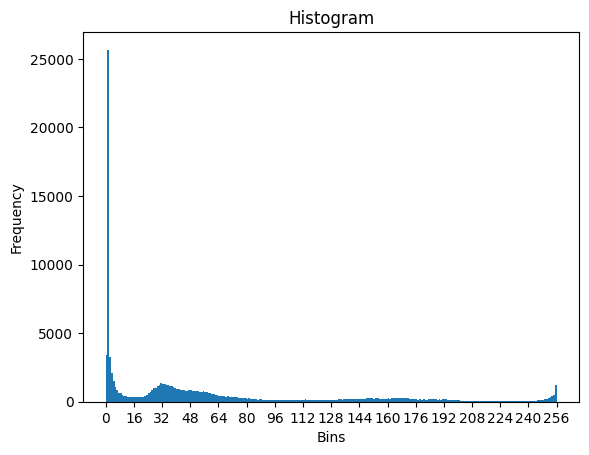

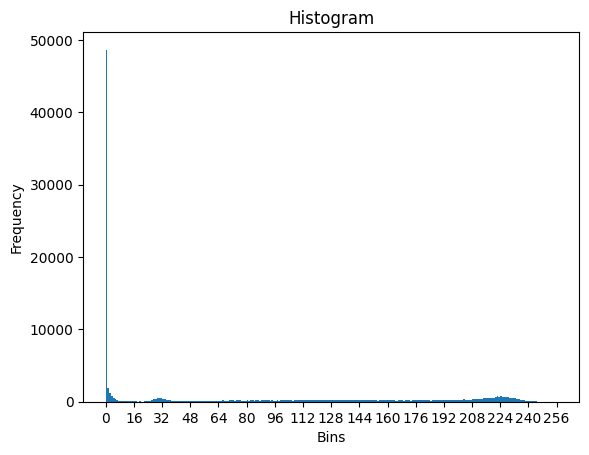

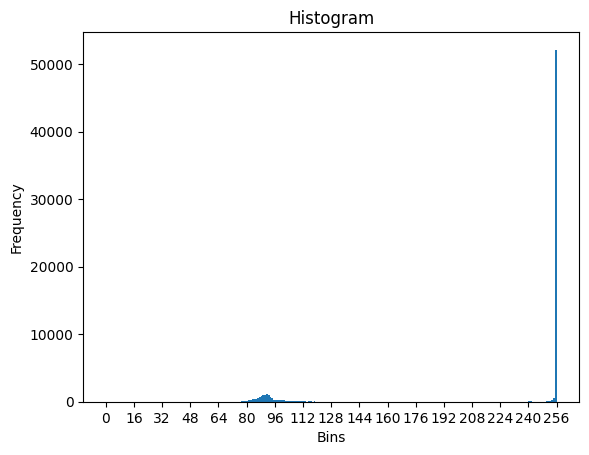

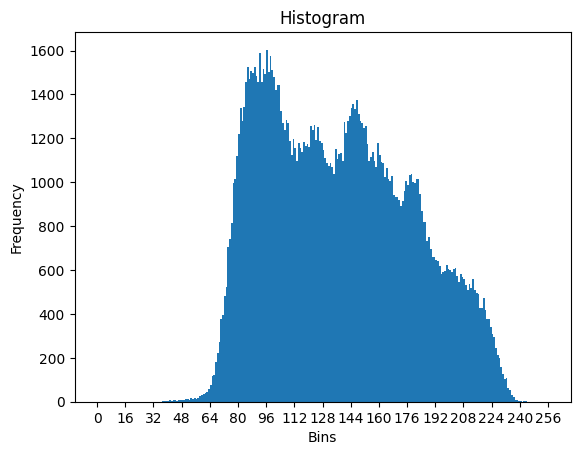

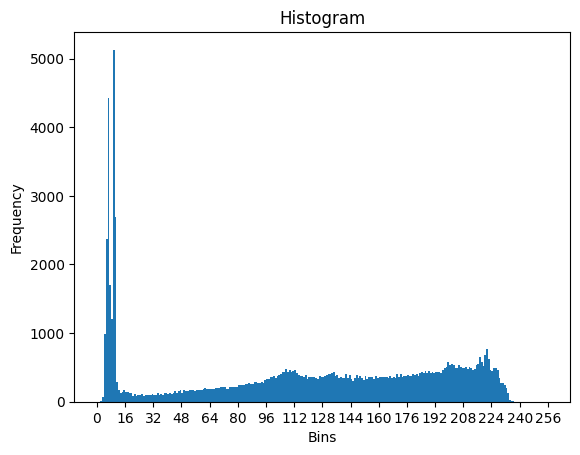

In [423]:
# converting images to gray-scale format

images_bw = []
for i in range(len(images)):
    images_bw.append(cv.cvtColor(images[i], cv.COLOR_BGR2GRAY))

saveAll(images_bw, '')
histList = makeHist(images_bw, 8)
showHist(images_bw, histList, 'grey', 16, True)
waitKey()

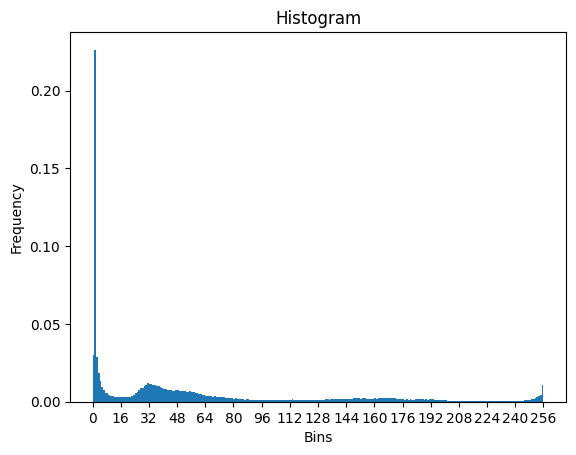

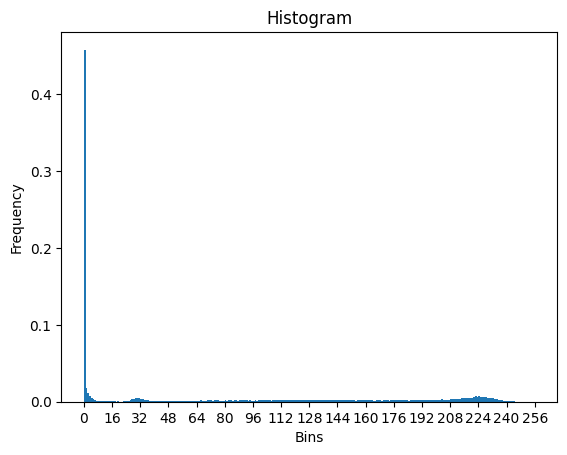

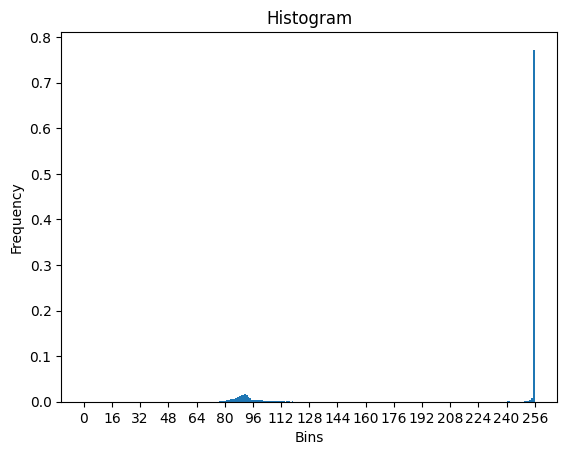

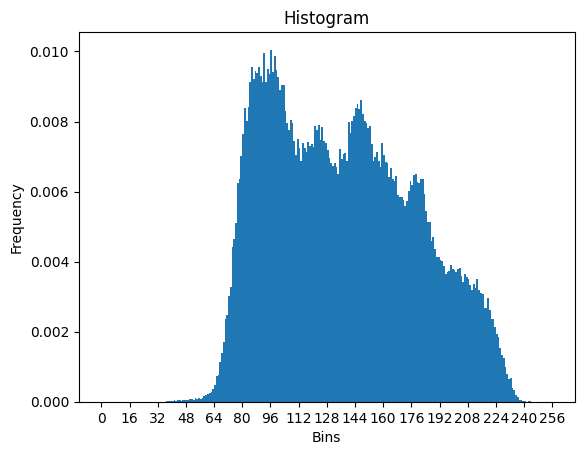

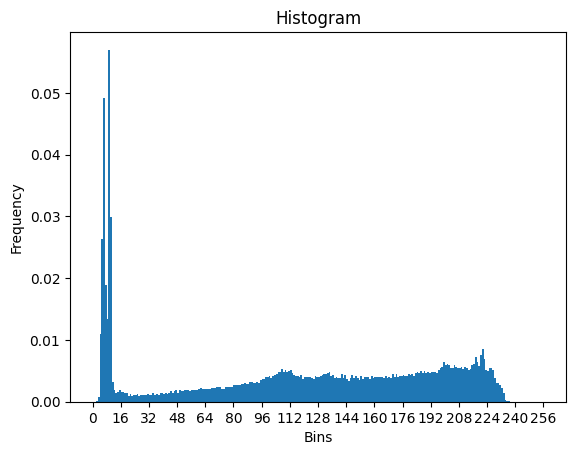

In [424]:
histList = normalizeHist(histList)
showHist(images_bw, histList, 'grey_normal', 16, True)
waitKey()

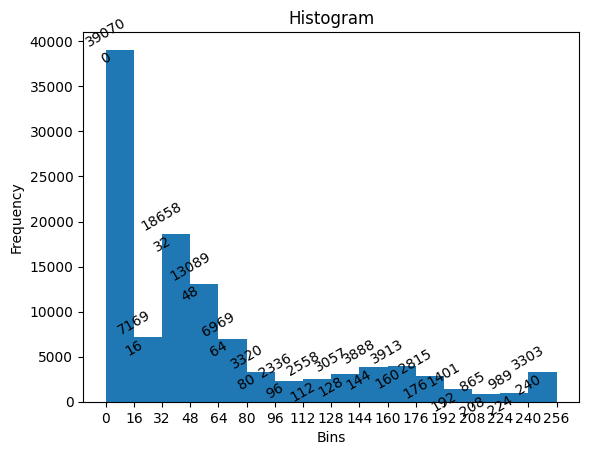

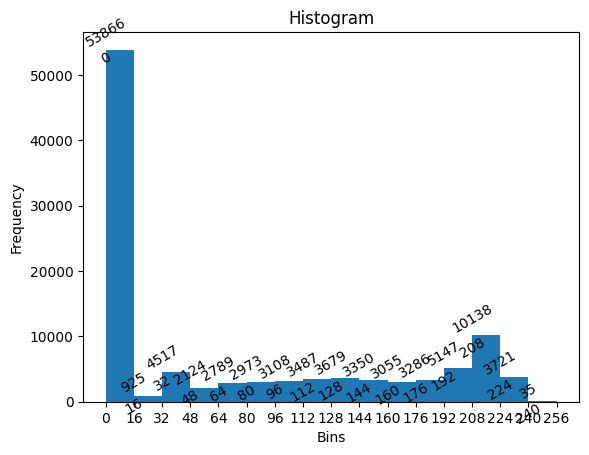

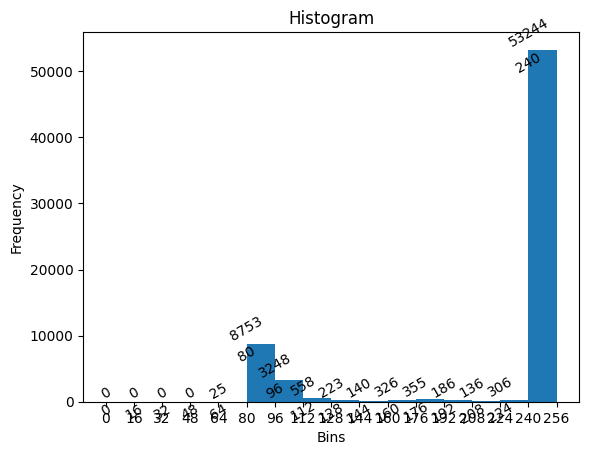

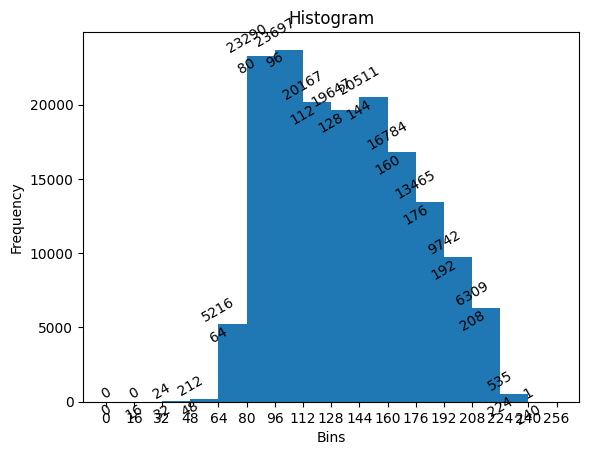

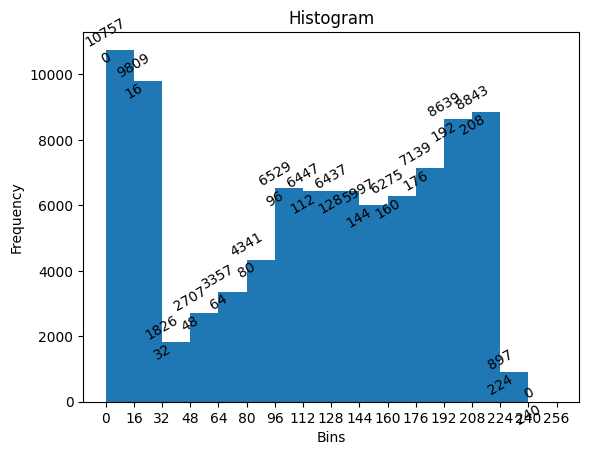

In [425]:
# using quantization with K-MEANS to reduce colors in images to 4 bits of resolution

images_formatted = requantization(images_bw, 4)
saveAll(images_formatted, " in 4 bits")
histList = makeHist(images_formatted, 4)
showHist(images_bw, histList, '4bts', 16, False)
waitKey()

In [426]:
np.unique(images_formatted[0])

array([  0,  17,  34,  51,  68,  85, 102, 119, 136, 153, 170, 187, 204,
       221, 238, 255])

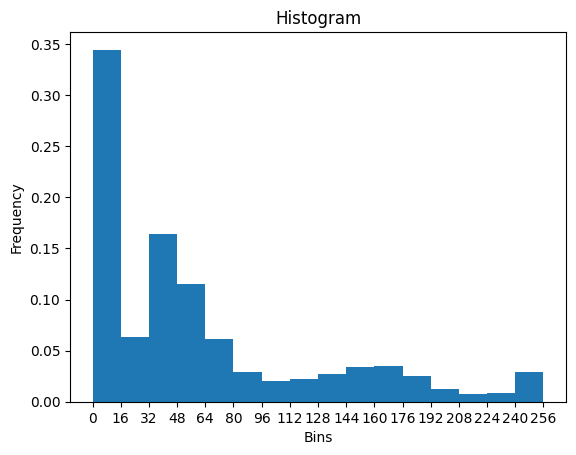

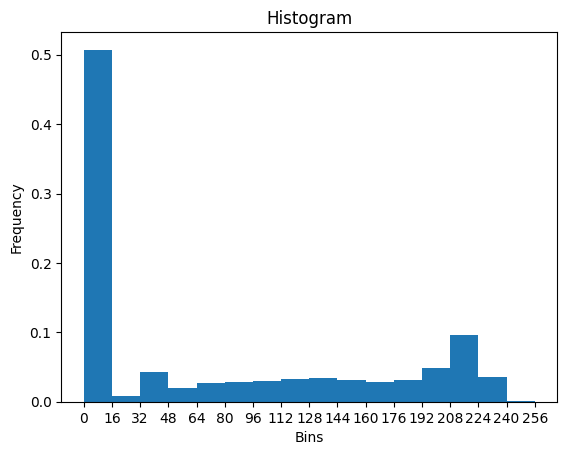

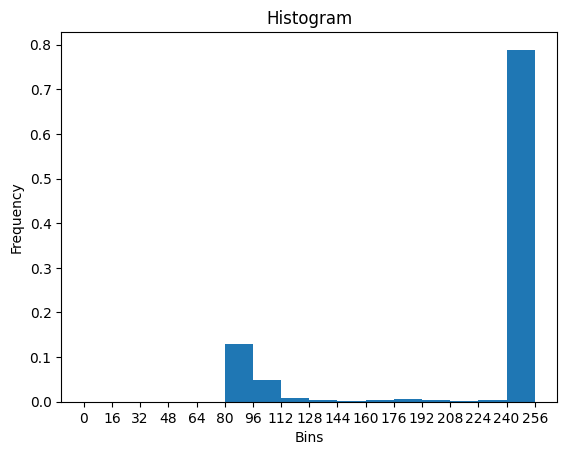

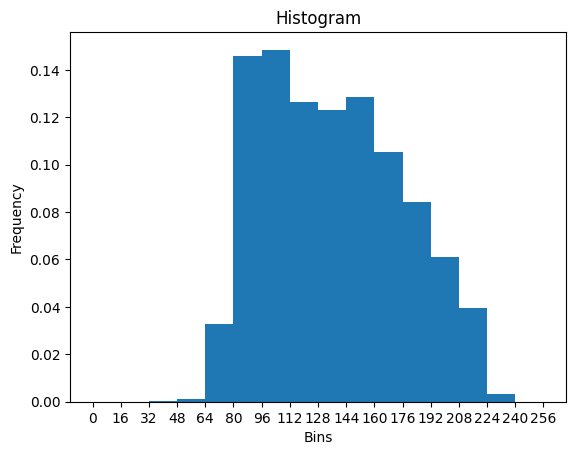

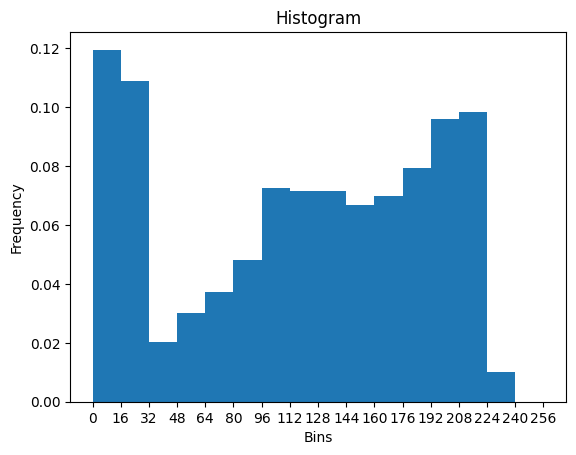

In [427]:
histList = normalizeHist(histList)
showHist(images_bw, histList, '4bts_normal', 16, True)
waitKey()

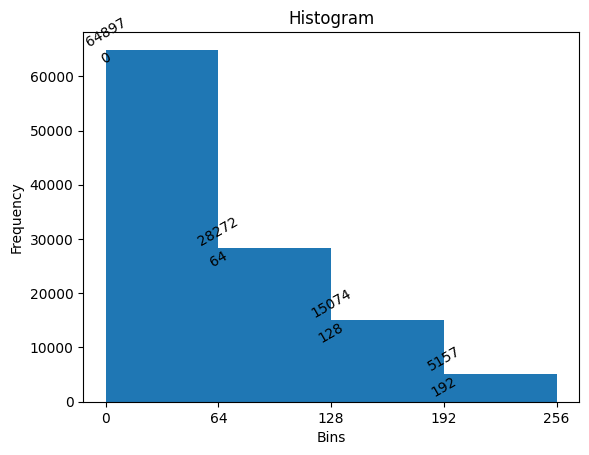

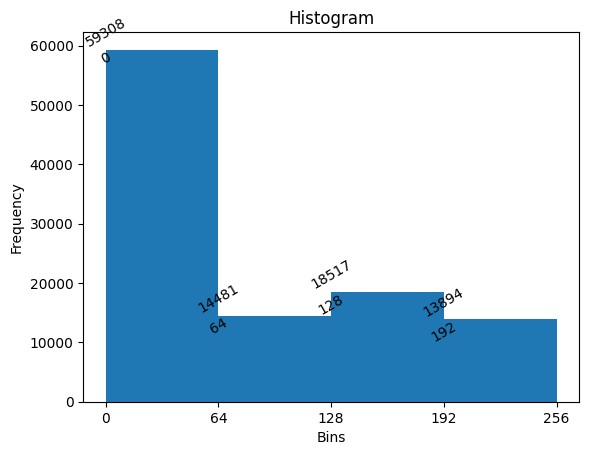

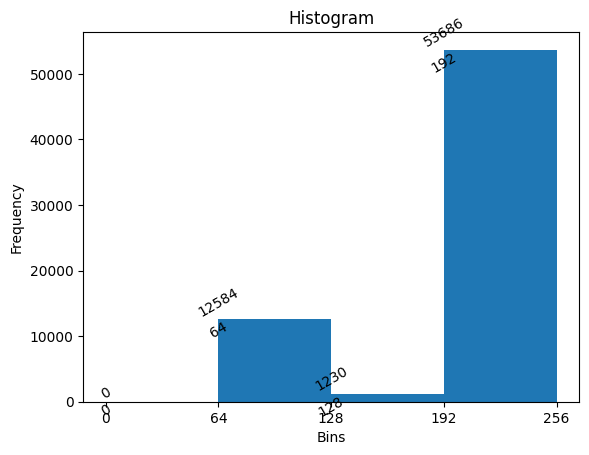

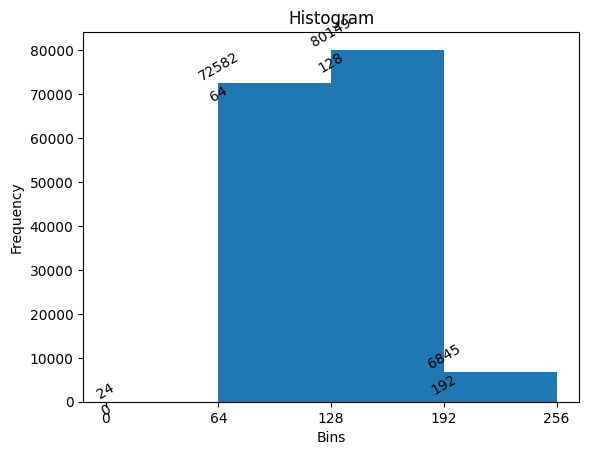

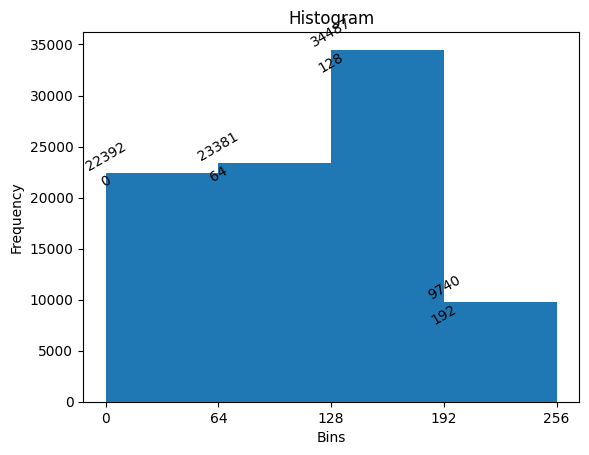

In [428]:
# repeating for 2 bits of resolution

images_formatted = requantization(images_bw, 2)
saveAll(images_formatted, " in 2 bits")
histList = makeHist(images_formatted, 2)
showHist(images_bw, histList, '2bts_normal', 4, False)
waitKey()

In [429]:
np.unique(images_formatted[0])

array([  0,  85, 170, 255])

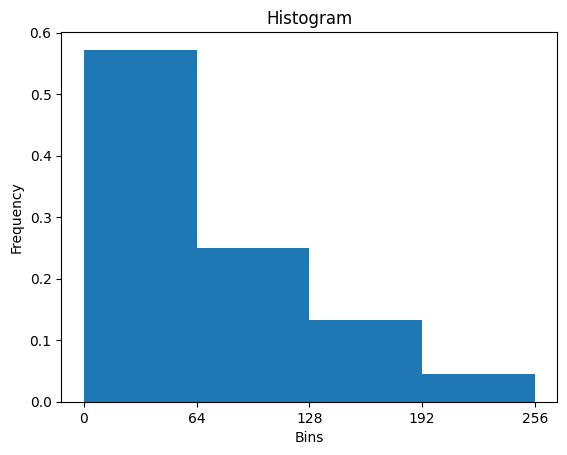

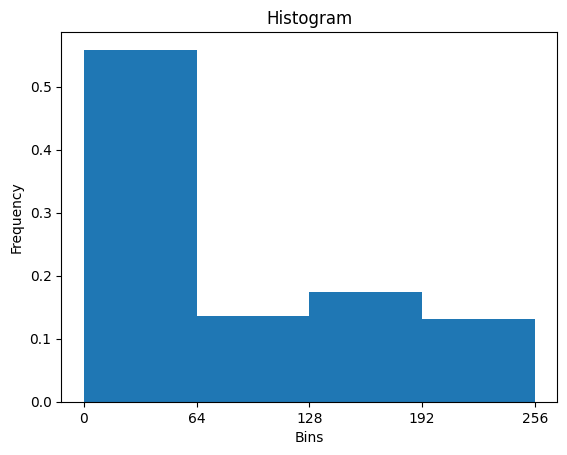

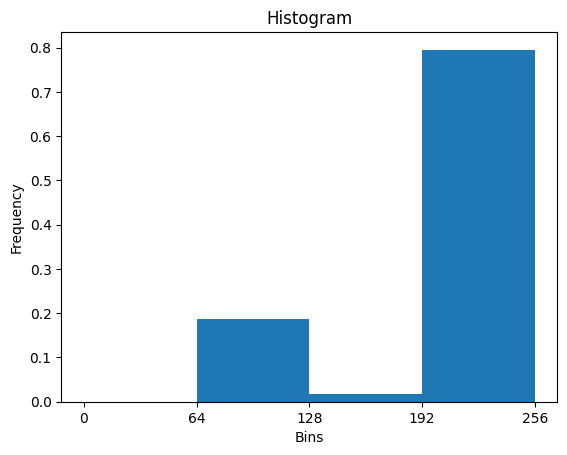

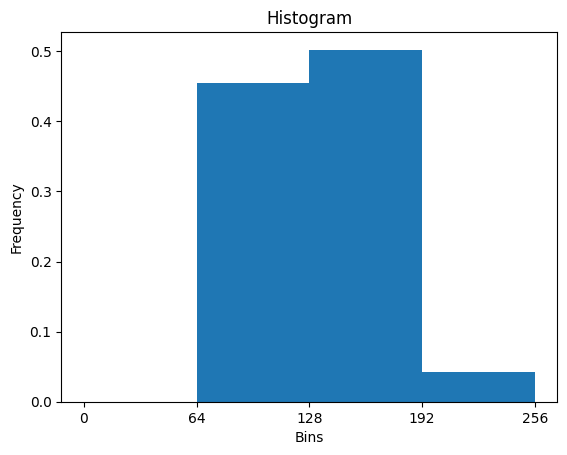

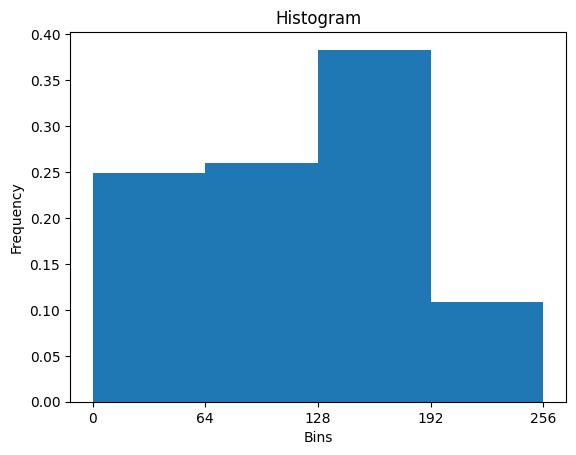

In [430]:
histList = normalizeHist(histList)
showHist(images_bw, histList, '2bts_normal', 4, True)
waitKey()

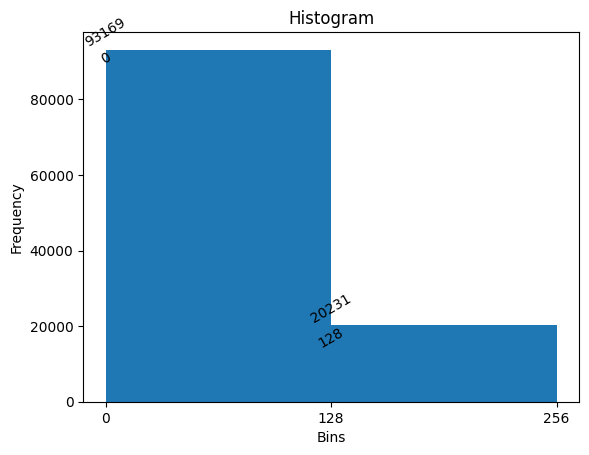

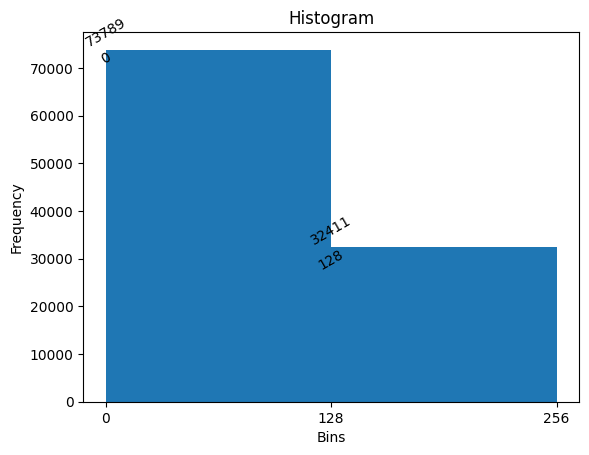

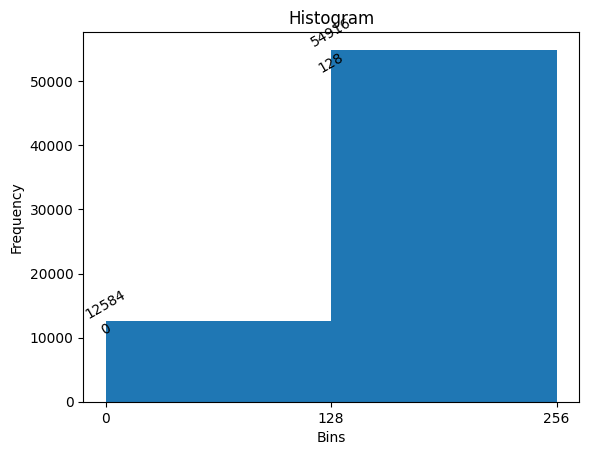

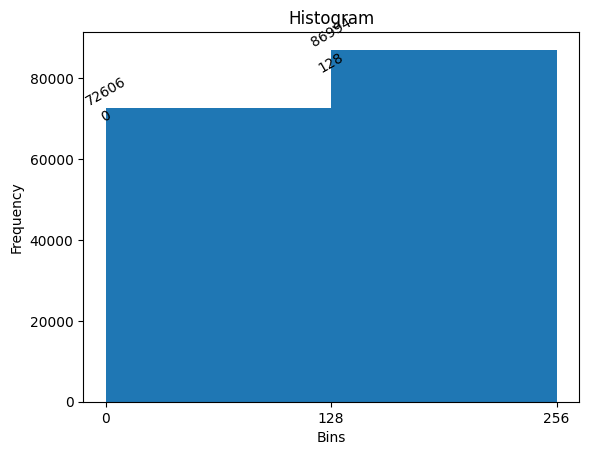

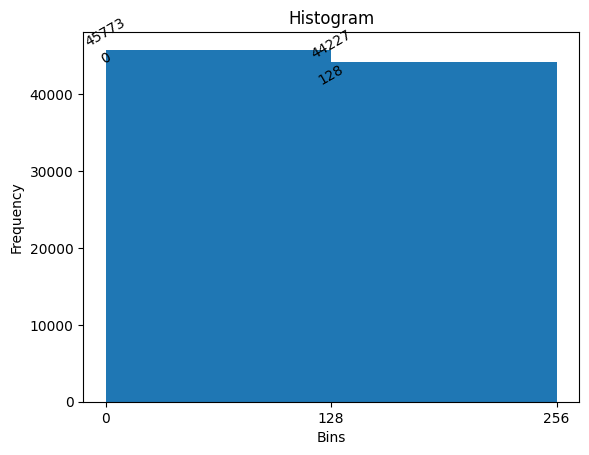

In [431]:
# repeating for 1 bit of resolution

images_formatted = requantization(images_bw, 1)
saveAll(images_formatted, " in 2 bits")
histList = makeHist(images_formatted, 1)
showHist(images_bw, histList, '1bts', 2, False)
waitKey()

In [432]:
np.unique(images_formatted[0])

array([  0, 255])

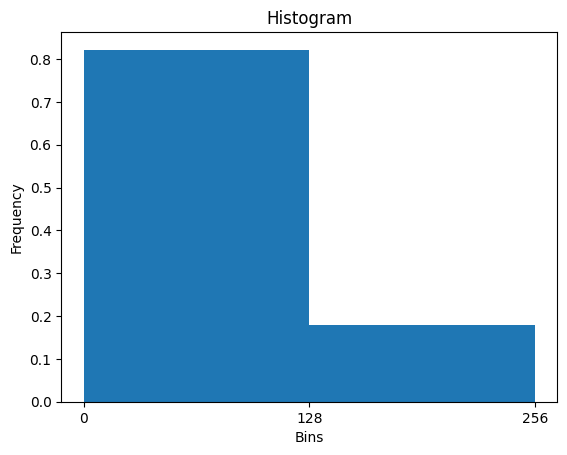

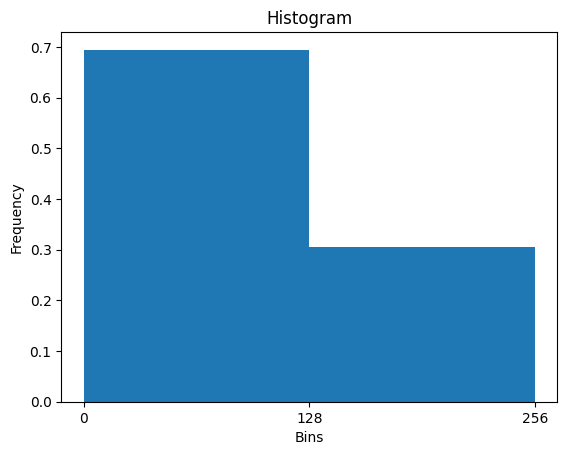

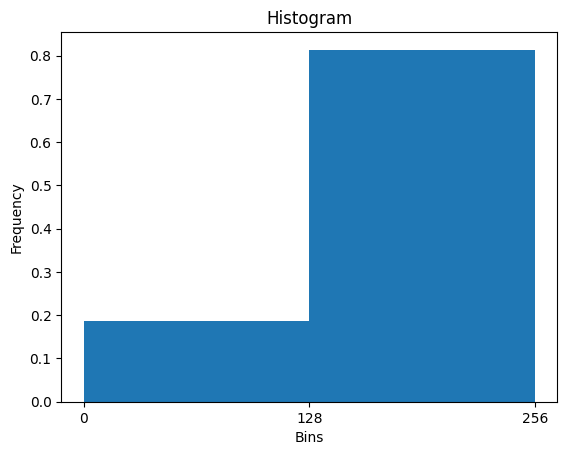

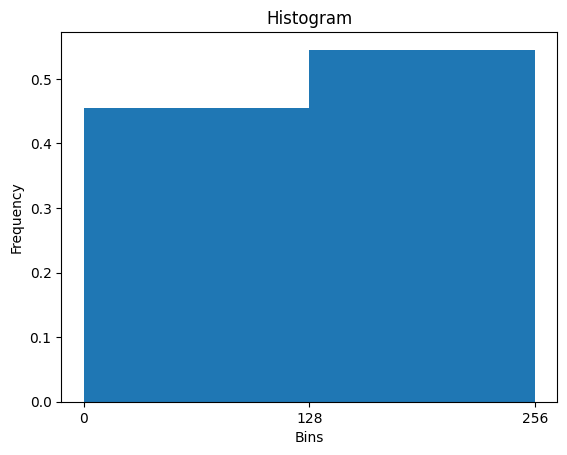

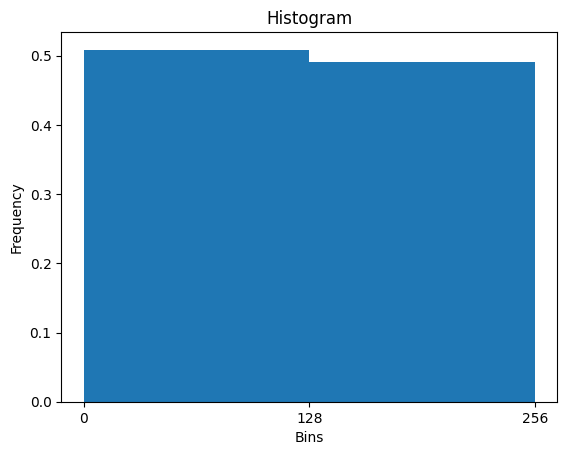

In [433]:
histList = normalizeHist(histList)
showHist(images_bw, histList, '1nts_normal', 2, True)
waitKey()

In [434]:
histList[0]

(array([0.82159612, 0.17840388]), array([  0, 128, 256]))